In [41]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from collections import Counter
import cv2
import convert_polygons as cp
import time

from numba import jit

import shapely.affinity as sa

In [33]:
image = cv2.imread("../images/test_pic.png", 0)
not image is None

True

In [34]:
c,h = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

len(c)

17

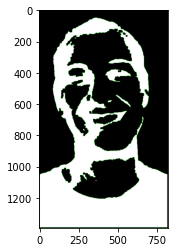

In [35]:
%matplotlib inline

test = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(test, c, -1, (0,255,0), 1)

plt.imshow(test)
plt.show()

In [36]:
import contour_fill_shapely as CFS

In [10]:
import importlib as IL
from shapely.geometry import Polygon, LineString, Point, MultiLineString

In [169]:
IL.reload(cp)
IL.reload(CFS)
p_list = cp.execute(image)

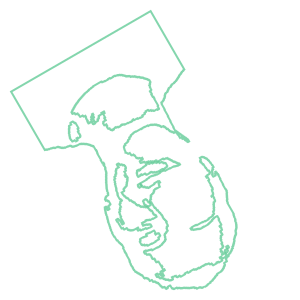

In [159]:
polygon = p_list[-1]

new = sa.rotate(polygon,np.pi/6, use_radians=True)

MultiLineString([new.exterior]+list(new.interiors))

In [171]:
all_points, contour_indices = CFS.generate_intersections(polygon, 5)

all_points.shape

(1298, 2)

In [14]:
def plot_path(path):
    
    X = []
    Y = []
    
    

    for p in list(path):
        X.append(p[0])
        Y.append(p[1])

    plt.plot(X,Y)

def plot_linestring(ls):
    
    X = []
    Y = []
    
    for p in list(ls.coords):
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y)

In [30]:
# generate the intersection points for a vertex
@jit(nopython=True)
def generate_intersections_numba(vertex_list, distance):
    
    intersections = []
    
    for i in range(len(vertex_list)-1):        
        p0 = vertex_list[i]
        p1 = vertex_list[i+1]
        
        dx = p1[0] - p0[0]
        dy = p1[1] - p0[1]
        
        if dy == 0:
            continue
            
        dxdy = dx/dy
        
        if p0[1] < p1[1]:
            indices = range(np.ceil(p0[1]/distance), np.ceil(p1[1]/distance))            
        else:
            indices = range(int(p0[1]/distance), int(p1[1]/distance), -1)

                        
        for j in indices:

            index = j * distance - p0[1]
            
            x = dxdy * index + p0[0]
            y = index + p0[1]

            intersections.append((x,y))
            
    return np.array(intersections)

In [139]:
# find peaks numba
@jit(nopython=True)
def remove_peaks(contour, intersections, mask):
    
    end = len(intersections)-1
    
    end = len(contour)
    # check if the points are on the vertex list
    for c in range(len(contour)):
        
        p1 = contour[c]
        
        # if the point is in intersections, check the previous and next point
        if ((p1[0] == intersections[:,0]) & (p1[1] == intersections[:,1])).any():
            
            p0 = contour[(c-1)%end]
            p2 = contour[(c+1)%end]
            
            d0 = p0[1]-p1[1]
            d2 = p2[1]-p1[1]
            
            # handle plateaus
            if d0 == 0:
                p0 = contour[(c-2)%end]
                d0 = p0[1]-p1[1]

            if d2 == 0:
                p2 = contour[(c+2)%end]
                d2 = p2[1]-p1[1]
                
            
            # check if the points are on the same or opposite sides of x axis through point p1
            sign = d2 * d0
            
            # sign >= 0 ~ points are on same side ~ peak
            if sign > 0:
                
                # find p1 in intersections
                index = np.where((p1[0] == intersections[:,0]) & (p1[1] == intersections[:,1]))[0][0]
                mask[index] = False

    return intersections[mask,:]


In [156]:
#%timeit -n 1000 generate_intersections_numba(np.random.randint(10,size=(10,2)), 0.01)

# vertex_list = np.random.randint(20,size=(10,2))

vertex_list = np.array(list(polygon.exterior.coords))

start = time.time()

d = 0.1

values = generate_intersections_numba(vertex_list, d)

print("Intersections:",time.time()-start)

values = remove_peaks(vertex_list, values, np.ones(values.shape[0], bool))

print("Peaks:",time.time()-start)




Intersections: 0.0023794174194335938
Peaks: 0.22443366050720215


In [175]:

# Testing function for remove peaks
'''
for i in np.unique(values[:,1]):
        
    if len(np.where(i*d==values[:,1])[0]) % 2 == 1:
        print("FAIL", i)
        break
'''            

'\nfor i in np.unique(values[:,1]):\n        \n    if len(np.where(i*d==values[:,1])[0]) % 2 == 1:\n        print("FAIL", i)\n        break\n'

In [173]:
import time
# get the next point

@jit(nopython=True) 
def next_point(point, contour_indices, all_points):
        
    i1 = np.where((all_points[:,0] == point[0]) & (all_points[:,1]==point[1]))[0][0]
    
    i0 = i1-1
    i2 = i1+1    
    
    if i0 in contour_indices:
        o = i0
        i0 = contour_indices[np.where(i0 == contour_indices)[0][0]+1] -1
        print("\t i0:",o,i0)
    elif i2 in contour_indices:
        o=i2
        i2 = contour_indices[np.where(i2 == contour_indices)[0][0]-1]
        print("\t i2:",o,i2)

        
    # check the previous point
    if all_points[i0][1] > point[1]:
        return all_points[i0]
    
    # check the next point
    if all_points[i2][1] > point[1]:
        return all_points[i2]    
    
    # if neither point returns
    return None


@jit(nopython=True) 
def across_point(point, all_points): 
        
    row = all_points[all_points[:,1]==point[1]][:,0]

    row.sort()
        
    index = np.where((row == point[0]))[0][0]
        
    if index % 2 == 0:
        return np.array([row[index+1], point[1]])
    else:
        return np.array([row[index-1], point[1]])
    
    
# find a point not in the path
@jit(nopython=True)
def get_available_pt_index(last_start,total_path, all_points):
        
    for i in range(last_start, len(all_points)):
        if ((total_path[:,0] == all_points[i,0]) & (total_path[:,1] == all_points[i,1])).any():
            continue
        else:
            return i
    
    return -1   
    

@jit(nopython=True)  
def numba_mode(start_index, all_points, contour_indices):    
        
    p1 = all_points[start_index]
    index = start_index
    
    path = []
    
    while not p1 is None:
        
        path.append(p1)
        p2 = across_point(p1, all_points)
        
        path.append(p2)
        p1 = next_point(p2, contour_indices, all_points)    
            
    return path
    

def fill_path_numba(all_points, contour_indices):
    
    total_path = []
    temp = []
    start_index = 0
    
    sort_points = all_points[all_points[:,1].argsort()]
        
    last_start = 0
    
    while last_start != -1:

        path = numba_mode(start_index, all_points, contour_indices)
                
        temp.extend(path)
        
        last_start = get_available_pt_index(last_start, np.array(temp), sort_points)
                
        if last_start != -1:
            start_point = sort_points[last_start]

            # get the start index in all points
            start_index = np.where((all_points[:,0]==start_point[0]) & (all_points[:,1]==start_point[1]))[0][0]

        total_path.append(path)

    return total_path

[   0  878  916 1058 1084 1090 1104 1264 1288 1292 1298]
	 i2: 878 0
	 i0: 0 877
	 i2: 1298 1292
	 i2: 1292 1288
	 i0: 1264 1287
	 i2: 1264 1104
	 i0: 1104 1263
	 i0: 1090 1103
	 i0: 1058 1083
	 i0: 916 1057
	 i2: 916 878


<IPython.core.display.Javascript object>


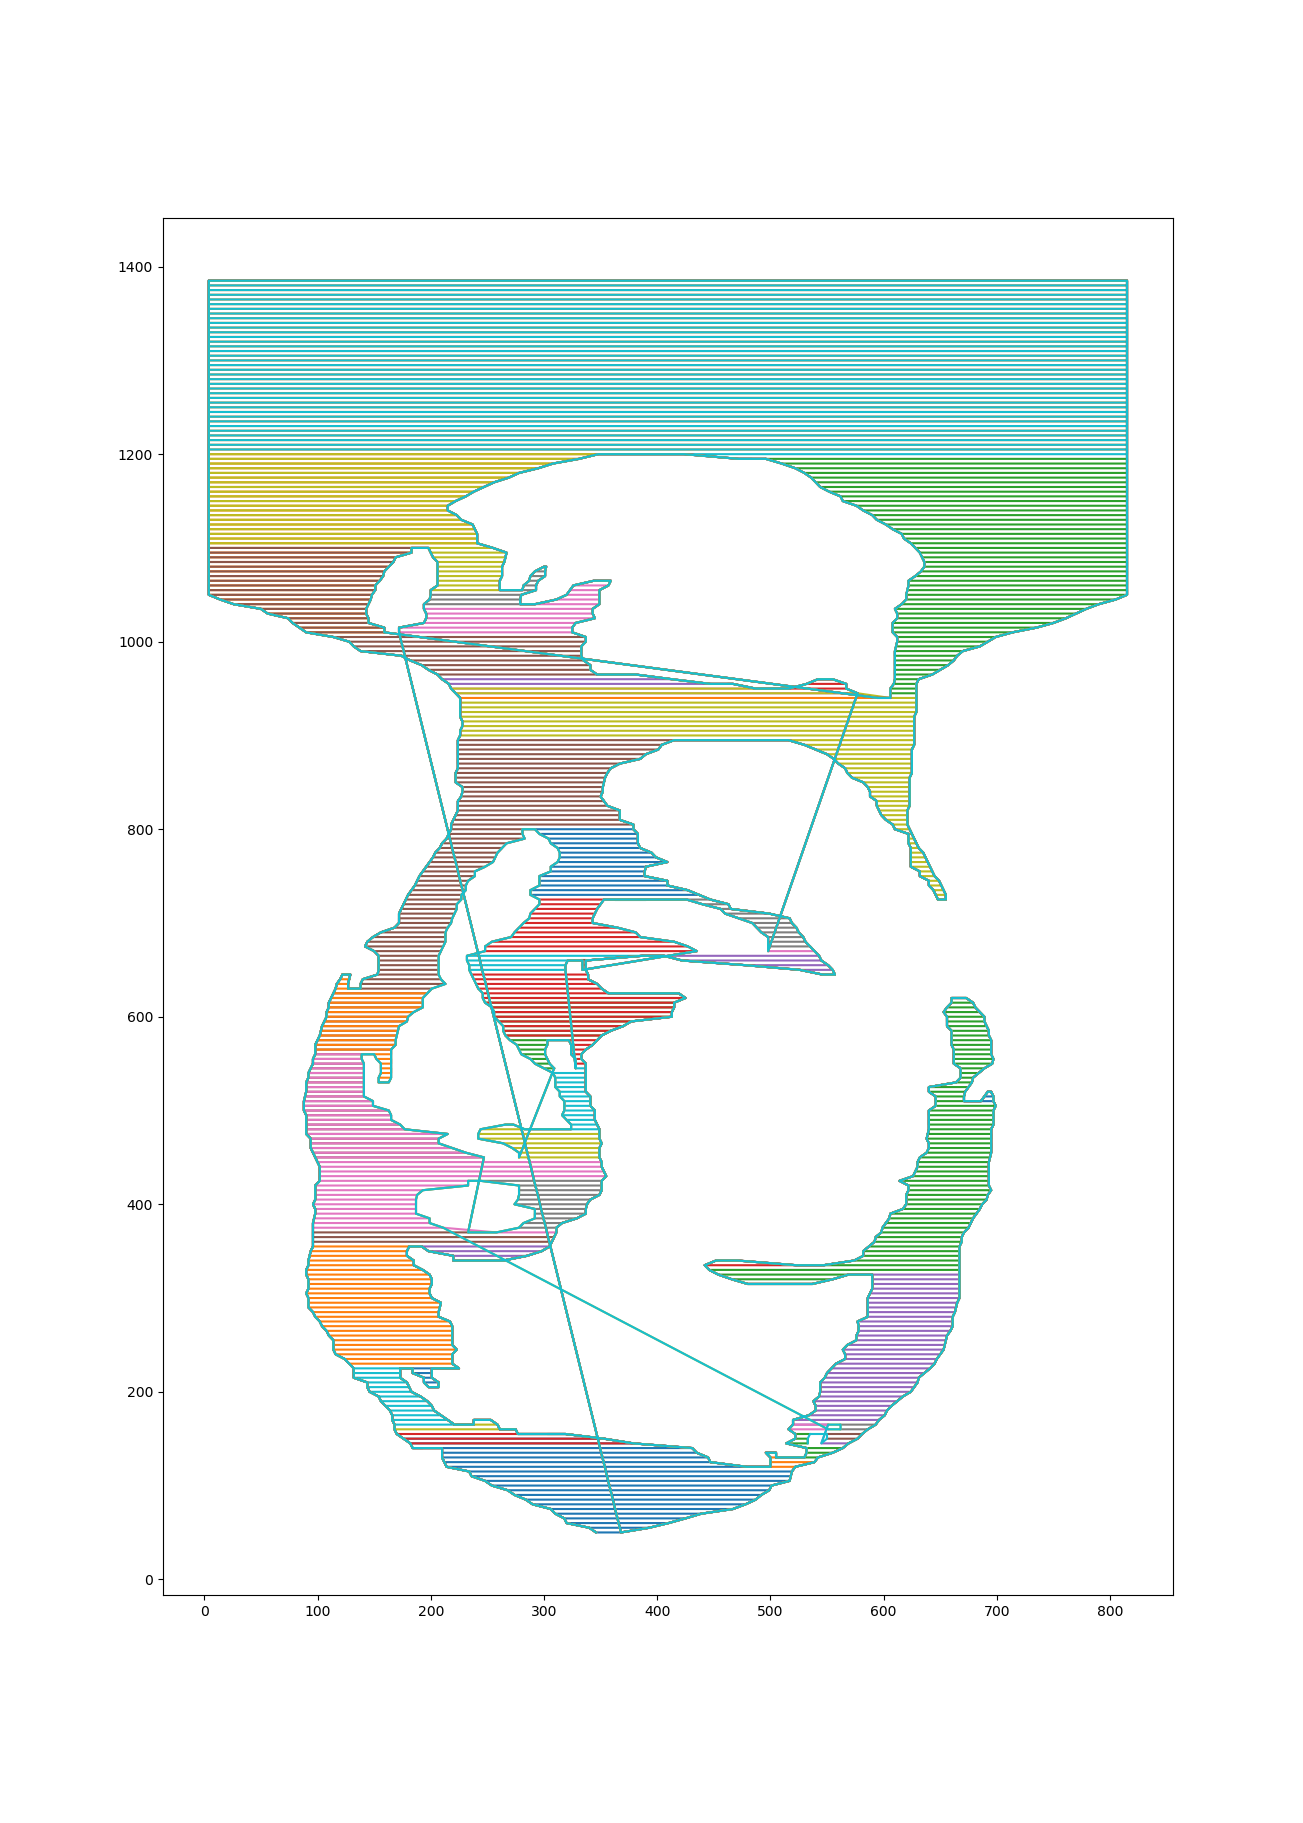

1552


In [181]:
%matplotlib notebook
print(contour_indices)

result = fill_path_numba(np.array(all_points), np.array(contour_indices))

pts = 0
for path in result:
    plot_path(list(path))
    pts += len(path)
    
# for p in all_points:
#     plt.scatter(p[0],p[1])
    
    
c0 = contour_indices[0]
for c1 in contour_indices[1:]:
    plot_path(all_points[c0:c1])
print(pts)

In [ ]:
# find a point not in the path
# @jit(nopython=True)
# def get_available_pt_index(last_start,total_path, all_points):
        
#     for i in range(last_start, len(all_points)):
#         if ((total_path[:,0] == all_points[i,0]) & (total_path[:,1] == all_points[i,1])).any():
#             continue
#         else:
#             return i
    
#     return -1



ap_ar = np.array(all_points)

sort_points = ap_ar[ap_ar[:,1].argsort()]

print(sort_points[0:10].shape)


get_available_pt_index(0, sort_points[0:-1], sort_points)


In [2]:
import numpy as np
x = [(0,1),(1,1),(2,1),(1,2),(0,3), (1,3),(2,3)]
x = np.array(x)

y = [(0,1),(2,1),(3,2)]
y = np.array(y)


In [ ]:
for p in y:
    print(((x[:,0]==p[0]) & (x[:,1]==p[1])).any())

In [7]:
np.append(x,y, axis=0)

array([[0, 1],
       [1, 1],
       [2, 1],
       [1, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [0, 1],
       [2, 1],
       [3, 2]])

In [ ]:
np.array(all_points)[0]

In [ ]:
y = np.array([1,2,3,4,5,6])
y

In [ ]:
np.where(y==1)[0][0]

In [ ]:
((x[:,0] == 1) & (x[:,1] == 4)).any()

In [ ]:
print(image.shape[0])

distance = image.shape[0] * 0.001

print(distance)

l1 = LineString(list(new.envelope.exterior.coords)[0:2])
l1 = l1.parallel_offset(0.5*distance, 'left')

test = MultiLineString([new.exterior]+list(new.interiors))


vertex_list = [p for p in new.exterior.coords]

for interior in new.interiors:
    vertex_list.extend([p for p in interior.coords])
# print(vertex_list)

intersection_list = []
contour_list = []

for _ in range(len(test)):
    contour_list.append([])
    
while l1.intersects(new):
    
    intersections = []

    for i, x in enumerate(test):
        if l1.intersects(x):
            
            values = x.intersection(l1)
            
            ip = list(values)
            
            contour_list[i].extend([(p.x,p.y) for p in ip])    
            intersections.extend(ip)
    
    intersection_list.append(intersections)
    
    l1 = l1.parallel_offset(distance, 'left')


print("INTERSECTIONS: DONE")
    
for i in range(len(intersection_list)):
    
    intersection_list[i].sort(key = lambda x: x.x)
    
print("SORT: DONE")

# sort the contour points
for i in range(len(contour_list)):
    
    # sort the points by the projection distance
    contour_list[i].sort(key=lambda x: test[i].project(Point(x)))
        
    # find the peaks in the contour
    peaks = find_peaks_numba(np.array(contour_list[i]))
    #peaks = find_peaks(contour_list[i])
    
    # remove the peaks from the contour and intersection list
    for p in peaks:
        
        print(p)
        
        contour_list[i].remove(p)
        
        for r, row in enumerate(intersection_list):
            if p in row:
                intersection_list[r].remove(p)
        # plt.scatter(p.x,p.y)
    plot_path(contour_list[i])

print("PEAKS: DONE")
    
    
